In [212]:
import os
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt

from src import cdf

In [213]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import isodate

**Problem**: We don’t fully understand the structure of these files and how columns relate. Therefore, after having read the netiob script, and the documentation we want to take a close look at the data itself.

**Goal**: Load xpt file into pandas in jupyter. Identify relevant columns and verify how they relate to another. For now, only for Insulin Data.

**Detailed Questions:**

1. How many patients
2. Fraction per pump system
3. Can we rely on the table as presented in T1DEXI ACRF_15Sept2022.pdf? or rather on the script?
   1. Do we have BASAL when the Bolus column is not empty?
   2. Are FATEST (test) and FACAT (category) really inconsistent between overall, 670g and 770g?
   3. Are there really no extended boluses in 770g?
   4. Is FASTRESN just a copy of the value in INSEXBOL or INSNMBOL and FAORRES (Basal)?


**How:**

- Load DX using pandas
  - unique count on USUBJID (subject counts)
  - value counts on DXTRT (patients/pump)
- Load FA (FACM) dataset
  - value counts on relevant columns
    - FATEST (insulin type)
      - INSSTYPE (subtype)
    - FATESTCD (bolus or basal category)
      - should only contain INSBASAL, INSBOLUS and BASFLRt
    - Comapre FATESTCD vs. INSDVSRC
  - Check if FAORRES (or rather FASTRESN (numeric)) result
    - is the same as either INSNMBOL, INSEXBOL

**Success:** jupyter notebook with analysis on the different columns and how they relate. Summary on where bolus, basal data is stored and differences between pumps.

## Load the xpt data file

In [387]:
t1dexi_path = os.path.join(os.getcwd(),'..','..','data','raw','T1DEXI')
dx = pd.read_sas(os.path.join(t1dexi_path,'DX.xpt'),encoding='latin-1').replace('', np.nan)
dx = dx.drop(columns=['DXSCAT','DXPRESP','STUDYID','DOMAIN','SPDEVID','DXSEQ','DXCAT','DXSCAT','DXSTRTPT','DXDTC','DXENRTPT','DXEVINTX','VISIT'])
display(dx.head())

#drop generic device codes that are duplicates of the true pump
#dx = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])]

,USUBJID,DXTRT
0,1,MULTIPLE DAILY INJECTIONS
1,1000,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
2,1000,INSULIN PUMP
3,1004,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
4,1004,INSULIN PUMP


In [382]:
facm = pd.read_sas(os.path.join(t1dexi_path,'FACM.xpt'),encoding='latin-1',).replace('', np.nan)

#'FAORRES','FASTRESC' and FASTRESN all show the finding (result) (however, 0 values show up as 5.397605e-79 in FASTRESN)
#`FAORRES`: Result or Finding in Original Units
#`FASTRESC`: Character Result/Finding in Std Format
#`FASTRESN`: Numeric Result/Finding in Standard Unit
facm['FAORRES'] = facm['FAORRES'].astype(float)

#FAORRESU and FASTRESU refer to the Unit but since U/hr is not a standard unit it is NaN in FASTRESU
#`FAORRESU`: Original Units
#`FASTRESU`: Standard Units
facm = facm.drop(columns=['STUDYID','DOMAIN','FASEQ',
                          'FASTRESN','FASTRESC',# Numeric results are 5.397605e-79 for 0 values, therefore use FAORRES (original units),FASTRESC is just a string duplicated
                          'FASTRESU', #standard units are NaN for U/hr , therefore use FAORRESU (original units)
                          ]) 

#alternatively we could use 
facm['FADTC'] = facm['FADTC'].apply(lambda x: datetime(1960, 1, 1) + timedelta(seconds=x) if pd.notnull(x) else pd.NaT)
facm['FADUR'] = facm.FADUR.dropna().apply(isodate.parse_duration, as_timedelta_if_possible=True)

#note, we didn't need to replace % signs and we didn't need xport as in the scripts
percent_count_facm = facm.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
percent_count_dx = dx.apply(lambda x: x.astype(str).str.contains('%').sum()).sum()
print(f'Number of % in facm: {percent_count_facm}, dx: {percent_count_dx}')

display(facm.sample(5))

Number of % in facm: 0, dx: 0


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL
1499635,48,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.190,U/hr,2019-12-21 10:41:17,0 days 00:05:00,NaN,NaN,NaN,NaN
1061,1004,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.206,U,2020-12-13 04:54:09,0 days 00:24:44,Pump,scheduled,NaN,NaN
119537,1077,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,1.885,U/hr,2019-12-19 03:10:45,0 days 00:05:02,NaN,NaN,NaN,NaN
2054821,870,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,3.111,U/hr,2020-06-04 02:05:31,0 days 00:05:01,NaN,NaN,NaN,NaN
1811785,702,INSBASAL,BASAL INSULIN,INSULIN,BASAL,0.189,U,2019-12-07 08:27:31,0 days 00:05:01,Pump,temp,NaN,NaN


## Inspect DX (Patients and Pumps)

In [388]:
#the duplicated 'INSULIN PUMP' or 'CLOSED LOOP INSULIN PUMP' values can be used to specify the pump type
pump_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])][['USUBJID','DXTRT']]
mdi_type = dx.loc[dx.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])]
other_type = dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])]
#print lentths of each
print(f'Pump: {len(pump_type)}, MDI: {len(mdi_type)}, Other: {len(other_type)}')

#use the redundant rows as treatment type and add those to new TRTMNT Colum (CSII, AID, MDI)
treatment_type = dx.loc[dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP','MULTIPLE DAILY INJECTIONS'])][['USUBJID','DXTRT']].rename(columns={'DXTRT':'TRTMNT'})
treatment_type['TRTMNT'] = treatment_type.TRTMNT.replace({'INSULIN PUMP':'CSII','CLOSED LOOP INSULIN PUMP':'AID','MULTIPLE DAILY INJECTIONS':'MDI'})
dx = pd.merge(dx.loc[~dx.DXTRT.isin(['INSULIN PUMP','CLOSED LOOP INSULIN PUMP'])], treatment_type, on='USUBJID',how='inner')
#display(dx.head())

#reduce
dx = dx[['USUBJID','TRTMNT','DXTRT']]
display(dx.head())

Pump: 414, MDI: 88, Other: 414


,USUBJID,TRTMNT,DXTRT
0,1,MDI,MULTIPLE DAILY INJECTIONS
1,1000,CSII,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
2,1004,CSII,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM
3,1010,CSII,MEDTRONIC 670G IN MANUAL MODE
4,1012,AID,TANDEM T:SLIM X2 WITH CONTROL IQ


In [389]:
#There are duplicated generic INSULIN PUMP rows
print(f'There are {dx.USUBJID.nunique()} unique subjects in the dx dataset')
print('These are broken down by devices as follows:')
#dx.groupby('DXTRT').agg({'USUBJID':'nunique'}).sort_values(by='USUBJID',ascending=False)
display(dx.value_counts('DXTRT'))
dx.value_counts(['TRTMNT','DXTRT'],sort=False)

There are 502 unique subjects in the dx dataset
These are broken down by devices as follows:


DXTRT
TANDEM T:SLIM X2 WITH CONTROL IQ             190
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    106
MULTIPLE DAILY INJECTIONS                     88
MEDTRONIC 670G IN AUTO MODE                   33
TANDEM T:SLIM X2 WITH BASAL IQ                23
MEDTRONIC 670G IN MANUAL MODE                 21
MEDTRONIC 630G                                 9
TANDEM T:SLIM X2                               8
TANDEM T:SLIM                                  5
MEDTRONIC PARADIGM 723 (REVEL)                 4
MEDTRONIC 670G                                 3
MEDTRONIC 770G                                 2
MEDTRONIC 770G IN AUTO MODE                    2
MEDTRONIC 751 (530G)                           2
MEDTRONIC 551 (530G)                           2
MEDTRONIC PARADIGM 523 (REVEL)                 1
MEDTRONIC PARADIGM 522                         1
MEDTRONIC 640G                                 1
INSULET OMNIPOD DASH                           1
Name: count, dtype: int64

TRTMNT  DXTRT                                    
AID     MEDTRONIC 670G IN AUTO MODE                   32
        MEDTRONIC 770G                                 1
        MEDTRONIC 770G IN AUTO MODE                    2
        TANDEM T:SLIM X2 WITH CONTROL IQ             190
CSII    INSULET OMNIPOD DASH                           1
        INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM    106
        MEDTRONIC 551 (530G)                           2
        MEDTRONIC 630G                                 9
        MEDTRONIC 640G                                 1
        MEDTRONIC 670G                                 3
        MEDTRONIC 670G IN AUTO MODE                    1
        MEDTRONIC 670G IN MANUAL MODE                 21
        MEDTRONIC 751 (530G)                           2
        MEDTRONIC 770G                                 1
        MEDTRONIC PARADIGM 522                         1
        MEDTRONIC PARADIGM 523 (REVEL)                 1
        MEDTRONIC PARADIGM 723 (REVEL)

In [390]:
## merge with dx
facm = pd.merge(facm, dx, on='USUBJID',how='left')

We can see some inconsistent classificaitons:  
 - 770G in the AID section is probably a 770G in Auto MODE
 - TANDEM T:SLIM X2 WITH BASAL IQ in the CSII are probably AID
 - MEDTRONIC 670G IN AUTO MODE in CSII are probably AID instead

So, can we trust this list? The netiob scripts made the following observation:  
>[Discretional]. We observed that subject ID: 766 device type should be 'MEDTRONIC 770G IN AUTO MODE' and we updated as such
        device_data.loc[device_data['USUBJID'] == '766', 'DXTRT'] = 'MEDTRONIC 770G IN AUTO MODE'

However, there are also many TANDEM with BASAL IQ, these could probbaly also be considered to be AID. Ultimately, the netiob script assigned the treatment based on the DXTRT name alone.   

**Conclusion**: ATM we don't know which one to use.

## FACM

- Load FA (FACM) dataset
  - value counts on relevant columns
    - FATEST (insulin type)
      - INSSTYPE (subtype)
    - FATESTCD (bolus or basal category)
      - should only contain INSBASAL, INSBOLUS and BASFLRt
    - Comapre FATESTCD vs. INSDVSRC
  - Check if FAORRES (or rather FASTRESN (numeric)) result
    - is the same as either INSNMBOL, INSEXBOL

Inspect Overall relationship between relevant columns

In [393]:
print(f'Overall number of rows in FACM {facm.shape[0]}')

vcounts= facm.value_counts(subset=['FAOBJ','FACAT','FATESTCD','FATEST','INSDVSRC','INSSTYPE'],sort=False,dropna=False)
display(vcounts)

#We see that source and sub type are NaN when fatest is basal flow rate. So do the units differ?
vcounts = facm.value_counts(subset=['FATEST','INSDVSRC','FAORRESU'],sort=False,dropna=False)
display(vcounts)

Overall number of rows in FACM 2219524


FAOBJ    FACAT  FATESTCD  FATEST           INSDVSRC    INSSTYPE                  
INSULIN  BASAL  BASFLRT   BASAL FLOW RATE  NaN         NaN                           1053401
                INSBASAL  BASAL INSULIN    Injections  NaN                              2365
                                           Pump        automated                      237033
                                                       scheduled                      258749
                                                       suspend                         14457
                                                       temp                           537986
                                                       NaN                              2811
         BOLUS  INSBOLUS  BOLUS INSULIN    Injections  NaN                              9516
                                           Pump        automated                        1619
                                                       automatic bolus/correction

FATEST           INSDVSRC    FAORRESU
BASAL FLOW RATE  NaN         U/hr        1053401
BASAL INSULIN    Injections  U              2365
                 Pump        U           1051036
BOLUS INSULIN    Injections  U              9516
                 Pump        U            103206
Name: count, dtype: int64

Observations
 1. `FAOBJ` is always INSULIN and can be ignored
 2. `FACAT` separates between BOLUS and BASAL
 3. `FATESTCD` and `FATEST` have the same meaning (basal, basal flow rate and bolus), Use FATEST because it is more explicit
 3. `INSTYPE` is *NaN* when device Source (`INSDVSRC`) is *NaN* or *Injections* and for some Basals with Pump source

### Basal Rates

We see that there are Basal Rates and Basal Flow Rates. The script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. Is this correct?  It is unclear if these are duplicates or if both need to be considered. Also, we see that there Are Basal Flow Rates in MDI. We want to check.

1. Checking how often these are available (by device)
   - when dropping Nan FASTRESN rows
2. Checking why there are BASAL FLOW Rates in MDI
3. Plotting BASAL FLOW Rates vs. BASAL INSULIN
4. Check if basal deliveries (U) modulate the basal delivery rates (U/hr)
 - Comparing sums (flow rates* duration  vs. basal deliveries)

**Success**: The above analysis were completed and a conclusion is drawn

#### Basal by Device Type

In [403]:
#as we see here, BASAL FLOW RATE and BASAL are present in all pumps
print('Number of entries per device type for which FATEST==BASAL FLOW RATE:')
flow_rates = facm.loc[facm.FATEST=='BASAL FLOW RATE']

#inspect NaN values in FAORRES
display(flow_rates.DXTRT.value_counts(sort=True, dropna=False))

print('show examples for rows where FAORRES (amount) is NaN:...')
display(flow_rates.loc[flow_rates.FAORRES.isna()].sample(2))
print('Number of basal flow rate rows for which the insulin amount (FASTRESN) is NaN')
print(f'{flow_rates.FAORRES.isna().sum()/len(flow_rates)*100:.2f}% overall')
print(f'{flow_rates.FADUR.isna().sum()/len(flow_rates)*100:.2f}% of durations are NaN')

#check if this is unique to basal flow rates
print(''); print('Breakdown of NaN insulin doses (FAORRES):')
display(facm.loc[facm.FAORRES.isna()].value_counts('FATEST'))
print(f'{(facm.FAORRES==0).sum()} FAORRES values are 0')

Number of entries per device type for which FATEST==BASAL FLOW RATE:


DXTRT
TANDEM T:SLIM X2 WITH CONTROL IQ             852614
MEDTRONIC 670G IN AUTO MODE                  150612
INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM     17425
TANDEM T:SLIM X2 WITH BASAL IQ                13761
MEDTRONIC 670G IN MANUAL MODE                  6370
MULTIPLE DAILY INJECTIONS                      2365
TANDEM T:SLIM X2                               2347
MEDTRONIC 630G                                 1862
MEDTRONIC 770G                                 1122
TANDEM T:SLIM                                  1093
MEDTRONIC PARADIGM 723 (REVEL)                  966
MEDTRONIC 640G                                  503
MEDTRONIC 670G                                  493
MEDTRONIC 751 (530G)                            472
MEDTRONIC 551 (530G)                            448
MEDTRONIC 770G IN AUTO MODE                     416
INSULET OMNIPOD DASH                            198
MEDTRONIC PARADIGM 522                          188
MEDTRONIC PARADIGM 523 (REVEL)                  146
Name: 

show examples for rows where FAORRES (amount) is NaN:...


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,TRTMNT,DXTRT
1779353,683,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,2019-08-15 08:20:54,NaT,NaN,NaN,NaN,NaN,MDI,MULTIPLE DAILY INJECTIONS
722421,1500,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,NaN,U/hr,2020-08-13 08:53:10,NaT,NaN,NaN,NaN,NaN,MDI,MULTIPLE DAILY INJECTIONS


Number of basal flow rate rows for which the insulin amount (FASTRESN) is NaN
1.55% overall
0.22% of durations are NaN

Breakdown of NaN insulin doses (FAORRES):


FATEST
BASAL FLOW RATE    16306
BASAL INSULIN      13942
Name: count, dtype: int64

159157 FAORRES values are 0:


 Observations:
 - We see that there are even basal flow rates for MDI, are these valid?
 - There are some rows for which the amount and duration are NaN, what does this mean?

#### Understand Basal Modulation and NaN Values
Now we check if basal deliveries (U) modulate the basal delivery rates (U/hr). We already know that there are no 0 Basal rates reported, so we check if NaN values could reflect 0 basal rates.

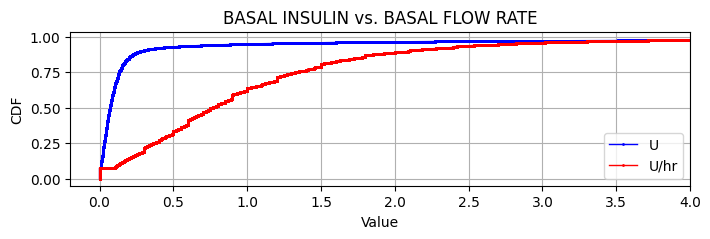

In [410]:
#what is the difference between basals in units and units/h, is there any diff?
plt.figure(figsize=(8,2));ax=plt.gca()
cdf.plot_cdf(facm.loc[facm.FATEST=='BASAL INSULIN'].FAORRES,ax=ax,color='blue',label='U')
cdf.plot_cdf(facm.loc[facm.FATEST=='BASAL FLOW RATE'].FAORRES,ax=ax,color='red',label='U/hr')
ax.set_xlim(-.2,4)
plt.title('BASAL INSULIN vs. BASAL FLOW RATE'); ax.legend()
plt.show()

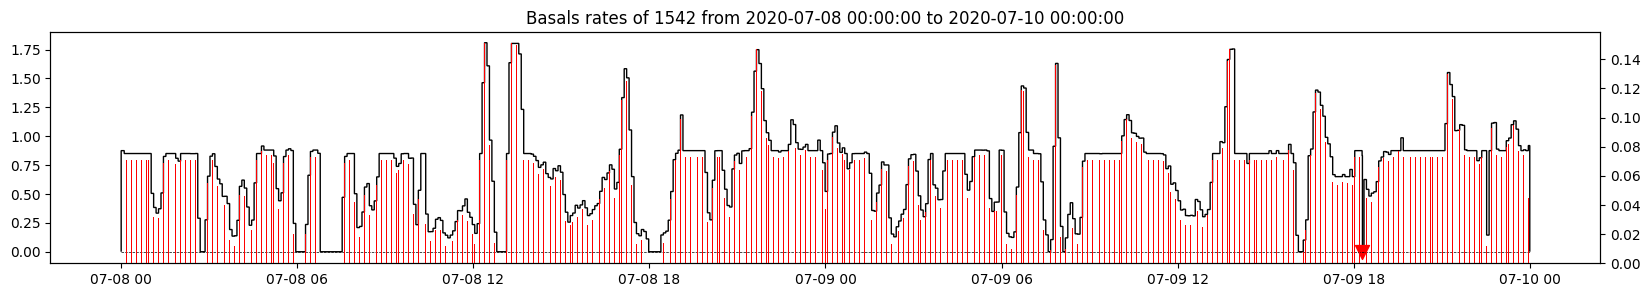

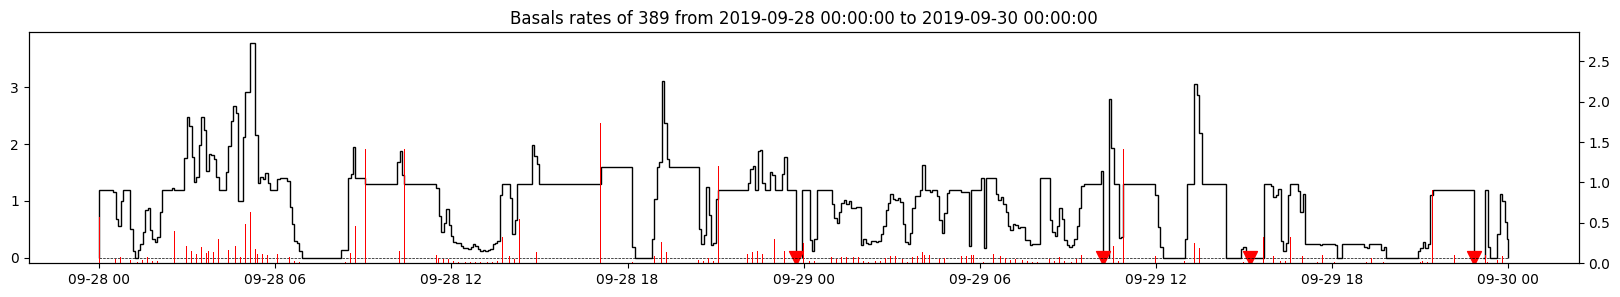

In [405]:
from src import drawing
from importlib import reload
reload(drawing)

#show an example of a flow rate and a basal within the same subject
#patient_id = np.random.choice(['1542', '1550','1286','389'])
for patient_id in ['1542', '389']:
    #patient_id = facm.loc[~facm.DXTRT.isin(['MULTIPLE DAILY INJECTIONS'])].USUBJID.sample(1).values[0]

    sub = facm.loc[(facm.USUBJID==patient_id)&(facm.FATEST.notna())].sort_values('FADTC')
    start = sub.FADTC.min()+timedelta(days=1)
    dur = timedelta(hours=48)
    sub = sub.loc[(sub.FADTC>=start)&(sub.FADTC<=start+dur)]

    #display(sub.head(3))
    #display(sub.groupby('FATEST')['FAORRES'].agg(['count', lambda x: x.isna().sum()]))

    sub_flow_rates = sub.loc[sub.FATEST=='BASAL FLOW RATE']
    sub_basals = sub.loc[sub.FATEST=='BASAL INSULIN']
    nan_flow_rates = sub_flow_rates.loc[sub_flow_rates.FAORRES.isna()]

    plt.figure(figsize=(20,3)); ax=plt.gca()
    #drawing.drawAbsoluteBasalRates()
    drawing.drawAbsoluteBasalRates(ax,sub_flow_rates.FADTC.values, sub_flow_rates.FAORRES.values,label='U/hr',hatch=None)
    #draw Nan Values as red xs at zero
    plt.scatter(nan_flow_rates.FADTC, [0]*len(nan_flow_rates), color='red', marker='v', s=100)
    twinx = ax.twinx()
    drawing.drawBoluses(twinx,sub_basals.FADTC, sub_basals.FAORRES,label='U',width=timedelta(minutes=1))
    plt.title(f'Basals rates of {patient_id} from {start} to {start+dur}'); 
    # Set ylim to current limits but reduce minimum by 0.1
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0] - 0.1, ylim[1])
    ax.hlines(0,start,start+dur,linestyles='dashed',colors='black',linewidth=0.5)
    #plt.show()
    #twinx.set_ylim(0,1)

Observations:
 1. Basal values seem to modulate the basal flow rate
 2. Nan values seem to mark 0 basal rates (at least in some cases) 

 The basal deliveries seem to happen every 5 minutes and module the basal rate (U/hr) (at least in the example above)
TODO: we can check by calculating the sum (using U/hr and duration) and compare it to the sum obtained on all basal values (U)


#### Check Why there are BASAL Rates in MDI patients.
#TODO:  

In [411]:
mdi_patients_with_flow_rates= facm.loc[(facm.DXTRT=='MULTIPLE DAILY INJECTIONS')&(facm.FATEST=='BASAL FLOW RATE')].USUBJID.unique()
print(f'There are {len(mdi_patients_with_flow_rates)} MDI patients with flow rates')
print(f'These make only {100*len(facm.loc[facm.USUBJID.isin(mdi_patients_with_flow_rates)])/len(facm):.2f} of the whole dataset')

There are 84 MDI patients with flow rates
These make only 0.64 of the whole dataset


In [412]:
#Where does the data sit in MDI
def isna(x):
    return x.isna().sum()
facm.loc[(facm.DXTRT=='MULTIPLE DAILY INJECTIONS')].groupby(['FATEST','FAORRESU'])[['FADTC','FADUR','INSSTYPE','INSNMBOL','INSEXBOL','FAORRES']].agg(['count',isna])

FADTC      FADUR       INSSTYPE       INSNMBOL        \
                         count isna count  isna    count  isna    count  isna   
FATEST          FAORRESU                                                        
BASAL FLOW RATE U/hr      2365    0     0  2365        0  2365        0  2365   
BASAL INSULIN   U         2365    0     0  2365        0  2365        0  2365   
BOLUS INSULIN   U         9515    0     0  9515        0  9515        0  9515   

                         INSEXBOL       FAORRES        
                            count  isna   count  isna  
FATEST          FAORRESU                               
BASAL FLOW RATE U/hr            0  2365       0  2365  
BASAL INSULIN   U               0  2365    2365     0  
BOLUS INSULIN   U               0  9515    9515     0

**Observation**: Even though there are BASAL FLOW RATE rows in MDI, there are only NaN values in all the insulin relevant columns

Now, let's check if the bolus and basal doses match between the two populations (in average)

In [ ]:
#Compare daily averages
facm['ISMDI']=facm.DXTRT=='MULTIPLE DAILY INJECTIONS'
facm['day'] = facm.FADTC.dt.date

#remove BASAL FLOW RATES from the dataset assuming that they reflect the same as the sum of BASAL INSULIN deliveries for Pump users (they are Nan for MDI any way)
temp = facm.loc[facm.FATEST!='BASAL FLOW RATE']
r = temp.groupby(['ISMDI','FATEST','USUBJID','day'])[['INSEXBOL','INSNMBOL','FAORRES']].agg('sum')
#bolus, basal per day
display(r.sample(3))
#sum per day
r = r.sum(axis=1)
display(r.sample(3))
#mean basal/bolus
r = r.groupby(level=[0, 1]).mean()
display(r)

,,,,INSEXBOL,INSNMBOL,FAORRES
ISMDI,FATEST,USUBJID,day,,,
False,BASAL INSULIN,1010,2019-12-26,0.0,0.0,33.808
True,BASAL INSULIN,174,2020-06-03,0.0,0.0,19.000
False,BOLUS INSULIN,1291,2020-03-11,0.0,7.1,7.100


ISMDI  FATEST         USUBJID  day       
True   BASAL INSULIN  410      2020-06-02     6.00000
False  BASAL INSULIN  674      2020-03-27    11.89400
       BOLUS INSULIN  1107     2019-12-28    96.10073
dtype: float64

ISMDI  FATEST       
False  BASAL INSULIN    20.650845
       BOLUS INSULIN    39.630819
True   BASAL INSULIN    19.176018
       BOLUS INSULIN    18.187278
dtype: float64

Why would MDI patients have 2x the bolus amount? Are there duplicates?

In [448]:
#How many rows are there that have values in more than one of the columns INSEXBOL	INSNMBOL	FAORRES
print('Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES')
display(facm[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1).value_counts().sort_index())

Number of values with values in more than one of the columns INSEXBOL, INSNMBOL, FAORRES


0      30248
1    2106017
2      80626
3       2633
Name: count, dtype: int64

In [449]:
#check for Rows with only 1 value
print('Rows with values in only 1 of the columns')
temp = facm.loc[facm[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == 1]
display(temp.sample(1))
display(temp.loc[temp.FATEST=='BOLUS INSULIN'].sample(1))
display(temp[['INSEXBOL','INSNMBOL','FAORRES']].count())
display(temp.FATEST.value_counts())
display(temp.value_counts(['FATEST','INSDVSRC','INSSTYPE'],dropna=False,sort=False))

#All injections end up in FAORRES only
print('Breakdown of columns used for Injections:')
display(facm.loc[facm.INSDVSRC=='Injections'][['FAORRES','INSNMBOL']].count())


Rows with values in only 1 of the columns


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,TRTMNT,DXTRT,ISMDI,day
2169025,974,BASFLRT,BASAL FLOW RATE,INSULIN,BASAL,0.352,U/hr,2019-08-26 19:59:02,0 days 00:04:59,NaN,NaN,NaN,NaN,AID,TANDEM T:SLIM X2 WITH CONTROL IQ,False,2019-08-26


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,TRTMNT,DXTRT,ISMDI,day
1110298,174,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,6.0,U,2020-05-31 23:02:19,NaT,Injections,NaN,NaN,NaN,MDI,MULTIPLE DAILY INJECTIONS,True,2020-05-31


INSEXBOL          0
INSNMBOL          0
FAORRES     2106017
dtype: int64

FATEST
BASAL INSULIN      1039459
BASAL FLOW RATE    1037095
BOLUS INSULIN        29463
Name: count, dtype: int64

FATEST           INSDVSRC    INSSTYPE                  
BASAL FLOW RATE  NaN         NaN                           1037095
BASAL INSULIN    Injections  NaN                              2365
                 Pump        automated                      237033
                             scheduled                      258749
                             suspend                           517
                             temp                           537985
                             NaN                              2810
BOLUS INSULIN    Injections  NaN                              9516
                 Pump        automatic bolus/correction         26
                             combination                        46
                             dual (normal part)                  1
                             dual (square part)                  1
                             normal                          19799
                             square                              1
      

Breakdown of columns used for Injections:


FAORRES     11881
INSNMBOL        0
dtype: int64

In [450]:
#Check rows with values in 2 columns
print('Rows with values in 2 columns')
temp = facm.loc[facm[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == 2]
display(temp.sample(2))
combination_counts = temp[['INSEXBOL','INSNMBOL','FAORRES']].apply(lambda row: tuple(row.dropna().index), axis=1).value_counts()
display(combination_counts)
display(temp.FATEST.value_counts())

Rows with values in 2 columns


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,TRTMNT,DXTRT,ISMDI,day
489004,1336,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,0.549,U,2019-11-10 17:16:34,NaT,Pump,normal,0.54887,NaN,AID,TANDEM T:SLIM X2 WITH CONTROL IQ,False,2019-11-10
627163,1422,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,1.300,U,2020-05-24 19:06:17,NaT,Pump,normal,1.30000,NaN,CSII,INSULET OMNIPOD INSULIN MANAGEMENT SYSTEM,False,2020-05-24


(INSNMBOL, FAORRES)    80276
(INSEXBOL, FAORRES)      350
Name: count, dtype: int64

FATEST
BOLUS INSULIN    80626
Name: count, dtype: int64

In [451]:
#Check rows with values in 3 columns
print('Rows with values in all 3 columns')
temp = facm.loc[facm[['INSEXBOL','INSNMBOL','FAORRES']].notna().sum(axis=1) == 3]
display(temp.sample(2))
combination_counts = temp[['INSEXBOL','INSNMBOL','FAORRES']].apply(lambda row: tuple(row.dropna().index), axis=1).value_counts()
display(combination_counts)
display(temp.FATEST.value_counts())

Rows with values in all 3 columns


,USUBJID,FATESTCD,FATEST,FAOBJ,FACAT,FAORRES,FAORRESU,FADTC,FADUR,INSDVSRC,INSSTYPE,INSNMBOL,INSEXBOL,TRTMNT,DXTRT,ISMDI,day
408314,127,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,0.375,U,2020-01-17 16:25:47,0 days 00:17:35,Pump,dual/square,0.2725,0.10219,AID,TANDEM T:SLIM X2 WITH CONTROL IQ,False,2020-01-17
93818,1067,INSBOLUS,BOLUS INSULIN,INSULIN,BOLUS,4.820,U,2020-02-09 15:42:38,0 days 02:00:00,Pump,dual/square,2.4750,2.34500,AID,TANDEM T:SLIM X2 WITH CONTROL IQ,False,2020-02-09


(INSEXBOL, INSNMBOL, FAORRES)    2633
Name: count, dtype: int64

FATEST
BOLUS INSULIN    2633
Name: count, dtype: int64

In [452]:
# we see that the sums don't match up for boluses, so if there are duplicates then the other row would have the bolus in both columns
facm.loc[facm.FATEST=='BOLUS INSULIN',['INSEXBOL','INSNMBOL','FAORRES']].sum()

INSEXBOL      6373.89908
INSNMBOL    204936.26185
FAORRES     261099.89600
dtype: float64

**Findings**
- The FAORRES mostly seems to be the sum of all deliveries
    - However, for 29463 BOluses, there is no value in INSMBOL and INSEXBOL
- When BASAL, INSMBOL, INSEXBOL are zero as expected
- When there is only one value, it is in FAORRESS, these are mostly BASAL but also some BOLUSES
  - All injections only show up in FAORRESS
  - But we also see pump boluses
  - TODO: Maybe, these are duplicates? Let's check if we see them reported twince


In [ ]:
facm[['FAORRES','INSNMBOL','INSEXBOL']].sum().plot(kind='bar',figsize=(5,2))

## Collected Questions
- Why are `TANDEM T:SLIM X2 WITH BASAL IQ` not considered AID?
- How do we know if Pump was running AID or not?
- The script only considers FATEST == 'BASAL INSULIN' thus ignoring BASAL FLOW RATE. Is this correct?
- Why are there many rows with NaN values in `FASTRESN` despite FATEST being BASAL INSULIN or BASAL FLOW RATE?  
- Why is FASTRES Nan when FAORRESU is U/hr but not when it is U?
- There are no 0 FASTRESN values but many NaN. How are 0 basal rates reported?
- Why are some boluses only in FAORRES but not in INSNMBOL and INSEXBOL